# Poisson Regression with Identity link

Poisson Regression involves regression models in which the response variable is in the form of counts.
In the case that your covariates would act additively, identity link is better than log link.
For example, in chromatography (GC/MS analysis) one would often measure the superimposed signal of several approx Gaussian shaped peaks and this superimposed signal is measured with an electron multiplier, which means that the measured signal are ion counts and therefore Poisson distributed. Since each of the peaks have by definition a positive height and act additively and the noise is Poisson, a nonnegative Poisson model with identity link would be appropriate here, and a log link Poisson model would be plain wrong.

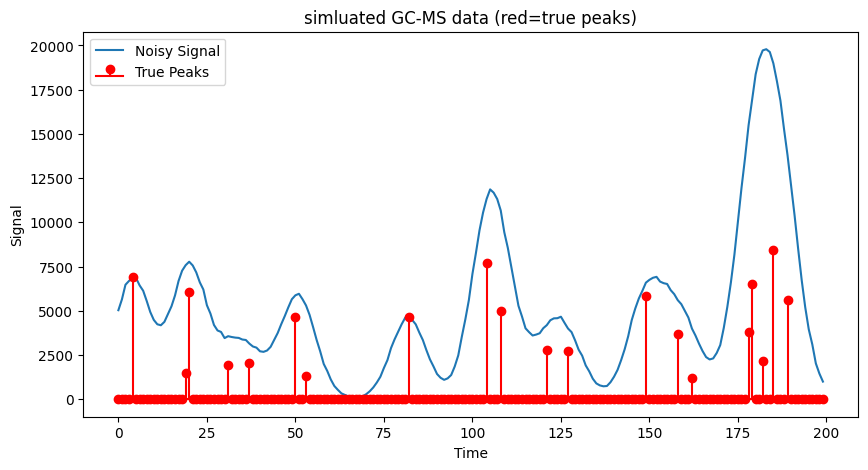

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_spike_train(n=200, npeaks=20, channels=1, peakhrange=(1000, 10000), seed=123, Plot=True):
    np.random.seed(seed)
    x = np.arange(n)
    
    # Ensure number of peaks does not exceed the number of points
    npeaks = min(npeaks, n)
    # Sample peak locations
    u = np.random.choice(x, npeaks, replace=False)
    u.sort()
    # Generate peak heights logarithmically within the specified range
    h = 10 ** np.random.uniform(np.log10(min(peakhrange)), np.log10(max(peakhrange)), (npeaks, channels))
    
    # Initialize the true coefficient array
    a = np.zeros((n, channels))
    a[u, :] = h
    
    # Gaussian peak shape function
    def gauspeak(x, u, w, h=1):
        return h * np.exp(-((x-u)**2) / (2 * w**2))
    
    # Create a banded matrix with Gaussian shapes
    W = 5  # width of the Gaussian
    X = np.column_stack([gauspeak(x, ui, W, 1) for ui in x])
    
    # Generate the noiseless simulated signal
    y_nonoise = X @ a
    # Add Poisson noise to the signal
    y = np.random.poisson(y_nonoise)
    
    # Plotting
    if Plot and channels == 1:
        plt.figure(figsize=(10, 5))
        plt.plot(x, y, label="Noisy Signal", linestyle='-', marker='')
        plt.stem(x, a, 'r', markerfmt='ro', label="True Peaks", basefmt="r-")
        plt.title("simluated GC-MS data (red=true peaks)")
        plt.xlabel("Time")
        plt.ylabel("Signal")
        plt.legend()
        plt.show()

    if Plot and channels > 1:
        plt.figure(figsize=(10, 8))
        plt.imshow(y.T**0.1, aspect='auto', interpolation='nearest')
        plt.colorbar(label='Noisy Signal (Power 0.1)')
        plt.xlabel('Time')
        plt.ylabel('Channel')
        plt.title('simluated GC-MS data (red=true peaks)')
        true_peaks = np.nonzero(a.sum(axis=1))[0]
        for peak in true_peaks:
            plt.axvline(x=peak, color='red', label='True Peaks' if peak == true_peaks[0] else "")
    
    return {'y': y, 'X': X, 'a': a, 'supp':u}

data = simulate_spike_train()

The mathematical equation for Poisson regression with identity link is

<a id='generation'></a>
$$
\begin{align}E(y) = \beta_0 + \beta_1 X_1+\beta_2 X_2+\dots+\beta_p X_p.\end{align} \tag{1}
$$

With $n$ independent data of the explanatory variables $x$ and the response variable $y$, we can estimate $\beta$ by minimizing the negative log-likelihood function under sparsity constraint:

<a id='loss'></a>
$$
\arg \min _{\beta \in R^p} L(\beta):=-\frac{1}{n} \sum_{i=1}^n\left\{y_i \log(x_i^T \beta)-x_i^T \beta-\log  \left(y!\right)\right\}, \text { s.t. }\|\beta\|_0 \leq s .\tag{2}
$$

However, since $\log(x_i^T \beta)$ requires that $x_i^T \beta$ be non-negative, this presents difficulties for optimization. One solution is to use a weighted non-negative least squares (weighted NNLS) loss function as an approximation.

Here is Python code for solving sparse poisson regression problem:

In [2]:
from jax import numpy as jnp

def loss(params, data):
    n, channels = data['y'].shape
    return jnp.sum(jnp.square((data['y'] - data['X'] @ params.reshape(n, channels))) / (data['y'] + 0.1))

Here is an example of recovering 20 true peaks from a noisy signal.

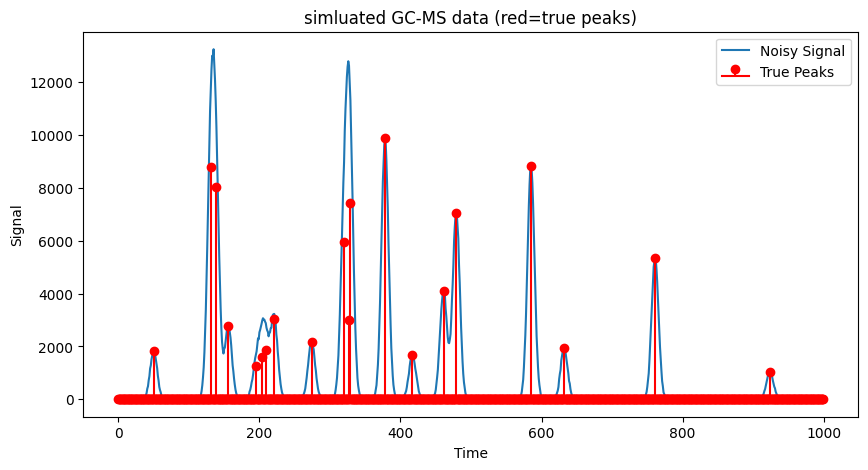

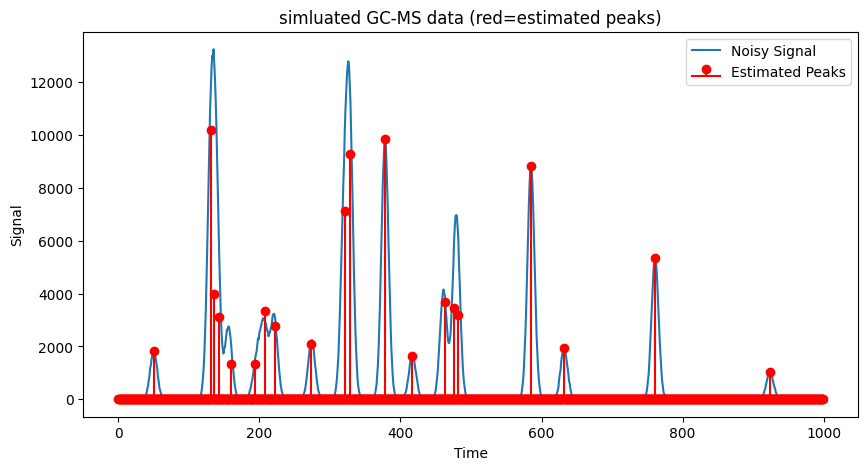

In [3]:
from skscope.layer import NonNegative
from skscope import ScopeSolver


n, npeaks, channels = 1000, 20, 1
data = simulate_spike_train(n, npeaks, channels, seed=123)

solver = ScopeSolver( 
    dimensionality=n*channels,
    sparsity=npeaks, 
)

solver.solve(
    objective=lambda params: loss(params, data),
    layers=[NonNegative(dimensionality = n*channels)],
    jit=True,
)
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(np.arange(n), data['y'], label="Noisy Signal", linestyle='-', marker='')
plt.stem(np.arange(n), solver.params, 'r', markerfmt='ro', label="Estimated Peaks", basefmt="r-")
plt.title("simluated GC-MS data (red=estimated peaks)")
plt.xlabel("Time")
plt.ylabel("Signal")
plt.legend()
plt.show()

Here is a multiple response example.

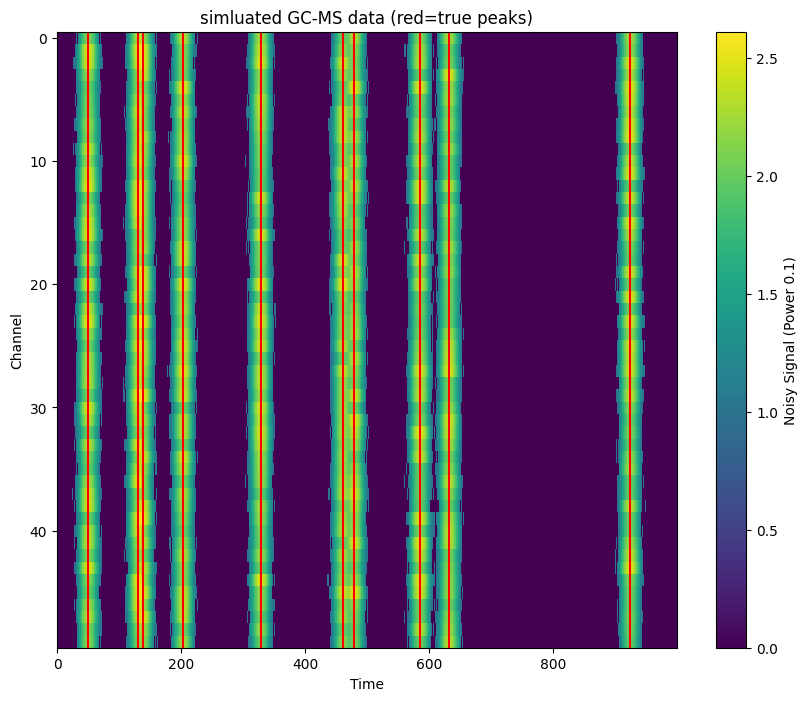

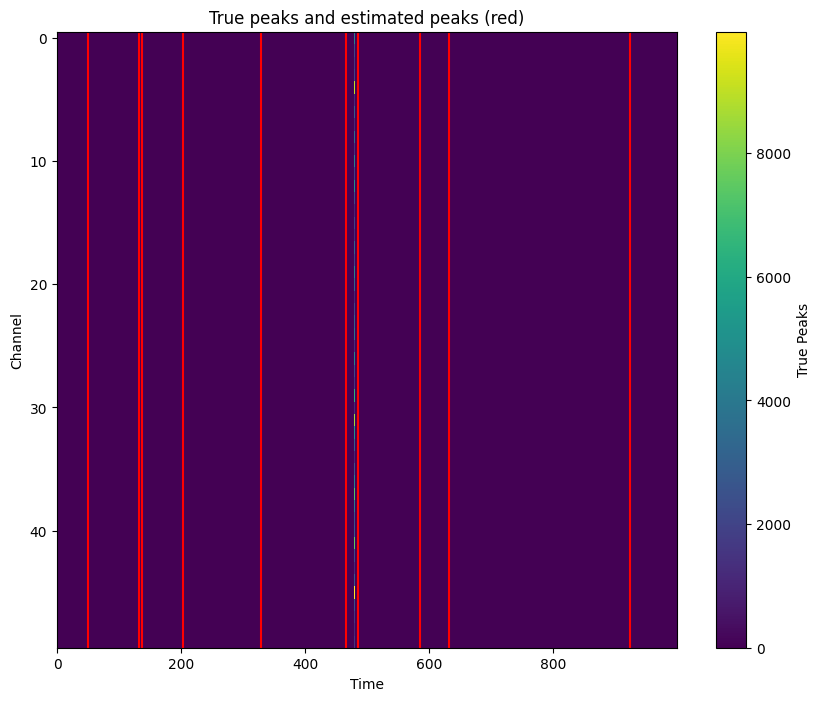

In [5]:
n, npeaks, channels = 1000, 10, 50
data = simulate_spike_train(n, npeaks, channels, seed=123)

solver = ScopeSolver( 
    dimensionality=n*channels,
    sparsity=npeaks, 
    group=[i for i in range(n) for _ in range(channels)],
)

solver.solve(
    objective=lambda params: loss(params, data),
    layers=[NonNegative(dimensionality = n*channels)],
    jit=True,
)
plt.figure(figsize=(10, 8))
plt.imshow(data['a'].T, aspect='auto', interpolation='nearest')
plt.colorbar(label='True Peaks')
plt.xlabel('Time')
plt.ylabel('Channel')
plt.title('True peaks and estimated peaks (red)')

true_peaks = np.nonzero(solver.params.reshape(n, channels).sum(axis=1))[0]
for peak in true_peaks:
    plt.axvline(x=peak, color='red', label='Estimated Peaks' if peak == true_peaks[0] else "")

The covariate matrix can be coded as a sparse matrix to save memory, but solving it will be more time-consuming. 

The size of dense covariate matrix is 7.62939453125 MB
The size of sparse covariate matrix is 1.4714584350585938 MB


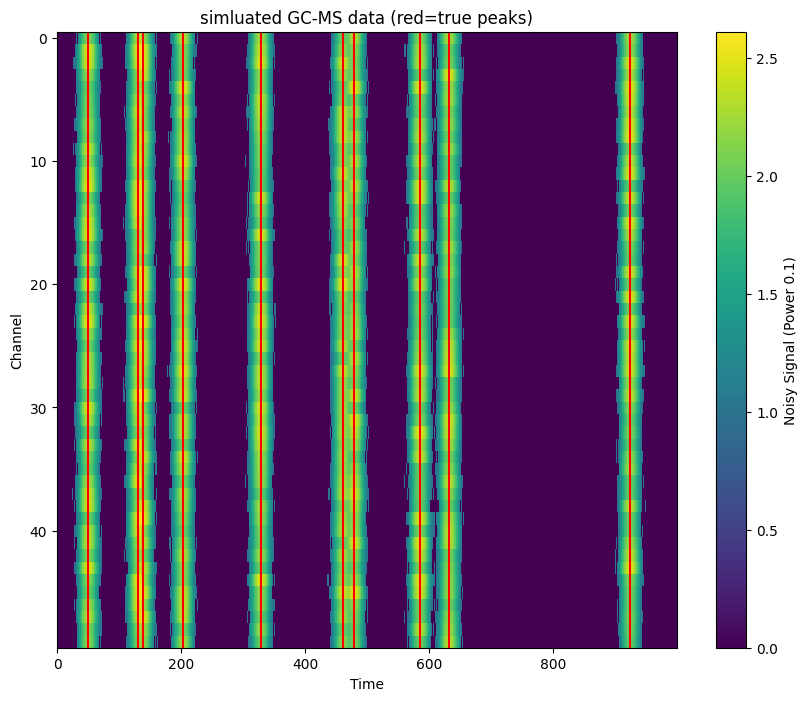

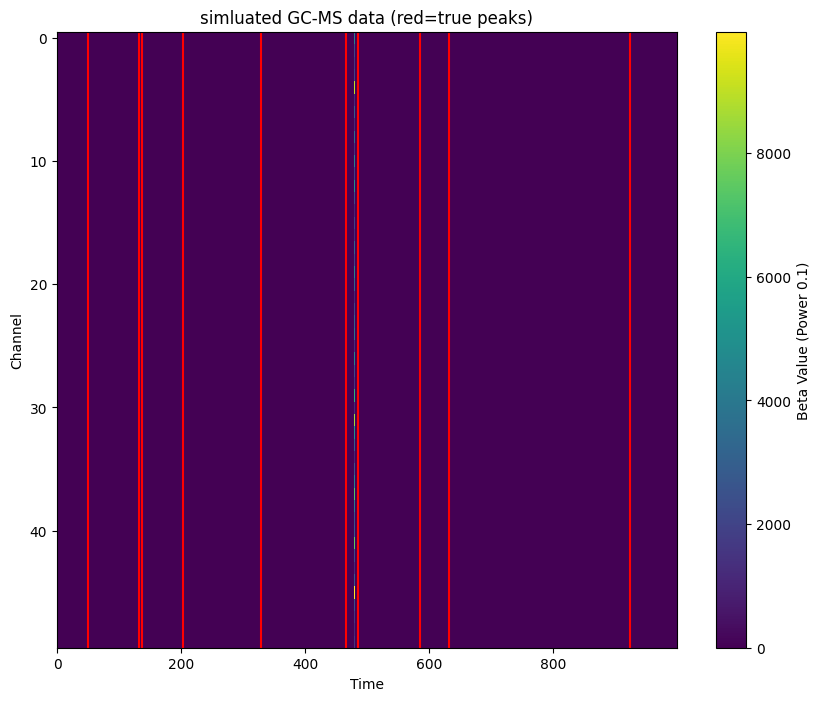

In [4]:
from jax.experimental import sparse

n, npeaks, channels = 1000, 10, 50
data = simulate_spike_train(n, npeaks, channels, seed=123)
print(f"The size of dense covariate matrix is {data['X'].nbytes / (1024**2)} MB")
data['X'] = sparse.BCOO.fromdense(data['X'])
print(f"The size of sparse covariate matrix is {(data['X'].data.nbytes + data['X'].indices.nbytes) / (1024**2)} MB")

solver = ScopeSolver( 
    dimensionality=n*channels,
    sparsity=npeaks, 
    sample_size=n,
    group=[i for i in range(n) for _ in range(channels)],
)

solver.solve(
    objective=lambda params: loss(params, data),
    layers=[NonNegative(dimensionality = n*channels)],
    jit=True,
)
plt.figure(figsize=(10, 8))
plt.imshow(data['a'].T, aspect='auto', interpolation='nearest')
plt.colorbar(label='Beta Value (Power 0.1)')
plt.xlabel('Time')
plt.ylabel('Channel')
plt.title('simluated GC-MS data (red=true peaks)')

true_peaks = np.nonzero(solver.params.reshape(n, channels).sum(axis=1))[0]
for peak in true_peaks:
    plt.axvline(x=peak, color='red', label='True Peaks' if peak == true_peaks[0] else "")

The last example shows the time consumption when the problem size is large in real situations.

In [5]:
from scipy.optimize import minimize
import numpy as np

def convex_solver_LBFGS(
    objective_func,
    value_and_grad,
    init_params,
    optim_variable_set,
    data,
):
    def fun(x):
        init_params[optim_variable_set] = x
        return objective_func(init_params, data)

    def jac(x):
        init_params[optim_variable_set] = x
        _, grad = value_and_grad(init_params, data)
        return np.array(grad[optim_variable_set], np.float64)

    bounds = [(0, None) for _ in init_params[optim_variable_set]]
    
    res = minimize(fun, init_params[optim_variable_set], method="L-BFGS-B", jac=jac, bounds=bounds)
    init_params[optim_variable_set] = res.x
    return res.fun, init_params

def grad(params, data):
    n, channels = data['y'].shape
    return -2 * (data['X'].T @ ((data['y'] - data['X'] @ params.reshape(n, channels)) / (data['y'] + 0.1))).flatten()

In [6]:
import time

n, npeaks, channels = 10000, 100, 500
data = simulate_spike_train(n, npeaks, channels, seed=123, Plot=False)
data['X'] = sparse.BCOO.fromdense(data['X'])
solver = ScopeSolver( 
    dimensionality=n*channels,
    sparsity=npeaks, 
    group=[i for i in range(n) for _ in range(channels)],
    numeric_solver=convex_solver_LBFGS,
)
start_time = time.time()
solver.solve(
    objective=lambda params: loss(params, data),
    gradient=lambda params: grad(params, data),
    jit=True,
)
print(f"Use {time.time() - start_time} s.")

: 

In [ ]:
from skscope.utilities import LinearGIC, GIC

n, npeaks, channels = 1000, 10, 50
data = simulate_spike_train(n, npeaks, channels, seed=123)

solver = ScopeSolver( 
    dimensionality=n*channels,
    sparsity=range(2*npeaks), 
    sample_size=n,
    ic_method=GIC,
    group=[i for i in range(n) for _ in range(channels)],
)

solver.solve(
    objective=lambda params: loss(params, data),
    layers=[NonNegative(dimensionality = n*channels)], # non-negative constraint
    jit=True,
)
plt.figure(figsize=(10, 8))
plt.imshow(data['a'].T, aspect='auto', interpolation='nearest')
plt.colorbar(label='Beta Value (Power 0.1)')
plt.xlabel('Time')
plt.ylabel('Channel')
plt.title('simluated GC-MS data (red=true peaks)')

true_peaks = np.nonzero(solver.params.reshape(n, channels).sum(axis=1))[0]
for peak in true_peaks:
    plt.axvline(x=peak, color='red', label='True Peaks' if peak == true_peaks[0] else "")